In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import get_cmap
import seaborn as sns
import string
import pickle # save data frame (results) in a .pkl file
import pandas as pd
from datetime import datetime
import os, sys
import re


sys.path.insert(0, 'C:/Users/ragna/Documents/Ragnar/Code/MMDGraph')
#from importlib import reload
from mmdutils import readfoldertopanda, PlotROCGeneral, plotVaryingBGDEG, findAUC
#reload(readfoldertopanda)
import importlib
importlib.reload(sys.modules['mmdutils'])
from mmdutils import readfoldertopanda, PlotROCGeneral, plotVaryingBGDEG, findAUC

In [2]:
keys = ['nr_nodes_1', 'nr_nodes_2', 'degree_1','degree_2', 'n', 'm']

# Graph Stats

In [3]:
GRAPHSTATS = readfoldertopanda("../data/BGDegreeLabel/GRAPHSTATS")
GRAPHSTATS.columns
#np.unique(GRAPHSTATS['nr_nodes_1'])

Index(['alpha', 'nr_nodes_1', 'nr_nodes_2', 'p_edge_1', 'p_edge_2', 'degree_1',
       'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm', 'timestap', 'B', 'N',
       'run_time', 'average_degree', 'median_degree', 'avg_neigh_degree',
       'avg_clustering', 'transitivity'],
      dtype='object')

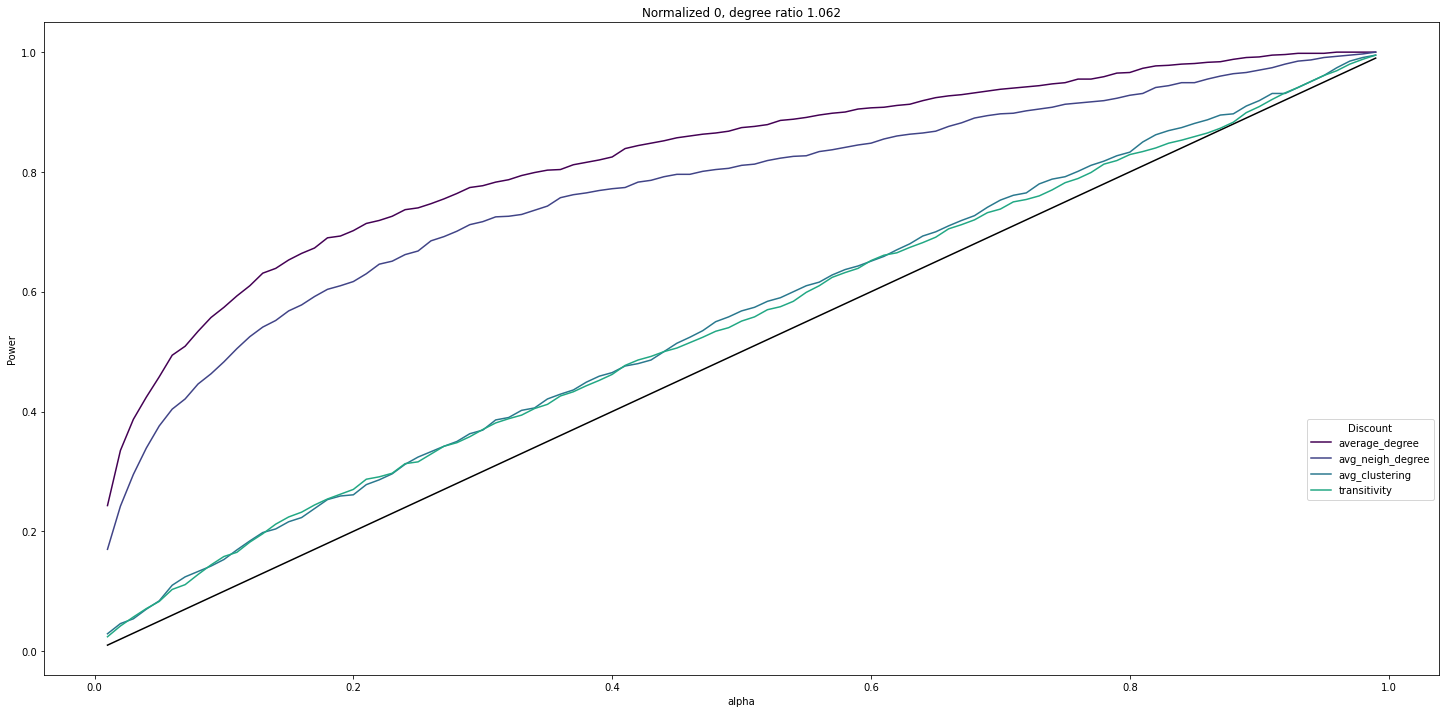

In [4]:
df = GRAPHSTATS
normalize = 0
v = sorted(np.unique(df['ratio_degree']))[0]
n1 = 20
n2 = n1
nr_nodes_1 = 60
nr_nodes_2 = nr_nodes_1

_, ax = plt.subplots(figsize = (25,12))


label = []
#icefire
cmap = get_cmap(sns.color_palette("viridis", as_cmap=True)) # type: matplotlib.colors.ListedColormap
colors = cmap.colors[::int(len(cmap.colors)/(4+1))]  # type: list

ab_line_plotted = False
graph_statistic_plotted = False


tmp = df.loc[(df['ratio_degree'] == v) & (df['n'] == n1) & (df['m'] == n2) & (df['nr_nodes_1'] == nr_nodes_1) & (df['nr_nodes_2'] == nr_nodes_2) ]

x = tmp['alpha']
if len(x)>0:
        ax.plot(x, x, color = 'black')
        ab_line_plotted = True



ax.plot(x, tmp['average_degree'], color =colors[0], label=str(v))
label.append('average_degree')

ax.plot(x, tmp['avg_neigh_degree'], color =colors[1], label=str(v))
label.append('avg_neigh_degree')

ax.plot(x, tmp['avg_clustering'], color =colors[2], label=str(v))
label.append('avg_clustering')

ax.plot(x, tmp['transitivity'], color =colors[3], label=str(v))
label.append('transitivity')



#ax.legend(label)
h, l = ax.get_legend_handles_labels()

ax.legend(handles=h, labels=label, 
        handler_map = {tuple: matplotlib.legend_handler.HandlerTuple(None)}, title = 'Discount', bbox_to_anchor=(1, 0.4))

ax.set_xlabel('alpha')
ax.set_ylabel('Power')
ax.set_title(f'Normalized {normalize}, degree ratio {v}')


plt.show()

In [5]:
GRAPHSTAT_AUC = findAUC(keys = keys, params = [], stats = ['average_degree'], df = GRAPHSTATS )

# WL

Let's see how the WL iterations affect the power

In [118]:
def readfoldertopandaWL(path):
    """
    Read files in a folder and concatenate them into an pandas data frame


    """
    onlyfiles = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    # read and append
    df = []
    cnt = 0
    for file in onlyfiles:
        tmp = pd.read_pickle(os.path.join(path, file))
        ok = file.rsplit("norm", 1)[-1]
        norm = int(re.findall(r'\d+', ok)[0])
        tmp['normalize'] = norm
        df.append(tmp)
        if cnt < 10:
            print(f'norm is {norm}')
            cnt += 1

    return pd.concat(df)

def get_wl_iteration(string_list):
    numbers_list = np.zeros(len(string_list))
    for i, input_string in enumerate(string_list):
        ok = input_string.rsplit("'n_iter'", 1)[-1]
        numbers_list[i] = int(re.findall(r'\d+', ok)[0])
    
    return numbers_list
            

In [130]:
WL = readfoldertopandaWL("../data/BGDegreeLabel/WLsubtree")
WL['wl_itr'] = get_wl_iteration(WL['kernel'])


norm is 0
norm is 0
norm is 0
norm is 0
norm is 0
norm is 1
norm is 1
norm is 1
norm is 1
norm is 1


In [131]:
WL.columns 

Index(['kernel', 'alpha', 'normalize', 'nr_nodes_1', 'nr_nodes_2', 'p_edge_1',
       'p_edge_2', 'degree_1', 'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm',
       'timestap', 'B', 'N', 'run_time', 'MMD_b', 'MMD_b_distfree', 'MMD_u',
       'MMD_u_distfree', 'nitr', 'with_labels', 'sinkhorn', 'average_degree',
       'median_degree', 'avg_neigh_degree', 'avg_clustering', 'transitivity',
       'wl_itr'],
      dtype='object')

In [121]:
# Because of some changes I created different coumns for same parameter. I need to put all the information into one parameter

WL.loc[WL['nitr'].isna(), 'nitr'] = WL.loc[WL['nitr'].isna(), 'wl_itr']

In [8]:
sorted(np.unique(WL['ratio_degree']))

[1.062, 1.125, 1.188, 1.25, 1.5]

c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


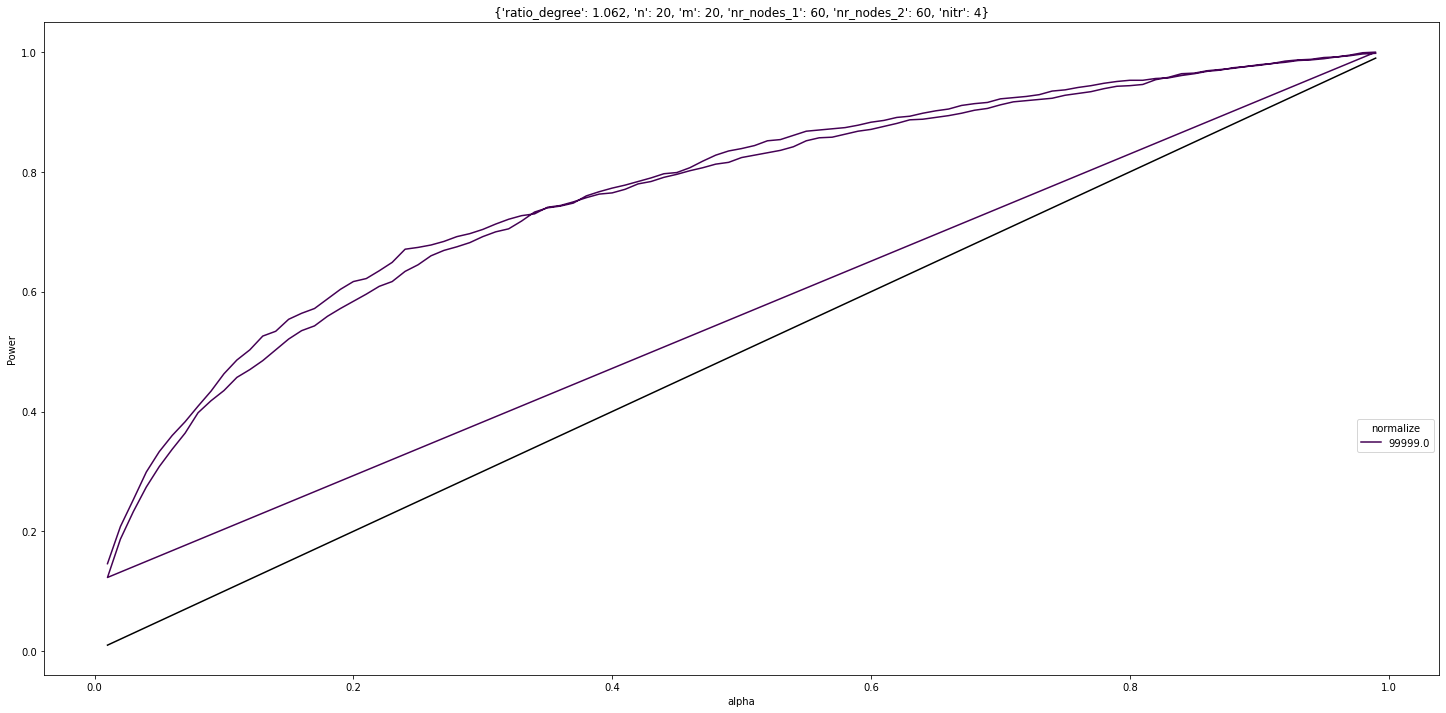

In [124]:
params_fixed = {'ratio_degree':sorted(np.unique(WL['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'nitr':4
                #'normalize':1
                }


plotVaryingBGDEG(df = WL.copy(), param_vary_name = "normalize", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")


For each unique row (number of samples, number of nodes, average degree combination), find best parameter combination, by calculating the area under the curve

In [132]:
wl_params = ['nitr', 'normalize']
WL_AUC = findAUC(keys = keys, params = wl_params, stats = ['MMD_b', 'MMD_u'], df = WL )

# Shortest Path



In [136]:
SP = readfoldertopandaWL("../data/BGDegreeLabel/SP")

norm is 0
norm is 1
norm is 0
norm is 1
norm is 0
norm is 1
norm is 0
norm is 1
norm is 0
norm is 1


In [137]:
SP.columns

Index(['kernel', 'alpha', 'nr_nodes_1', 'nr_nodes_2', 'p_edge_1', 'p_edge_2',
       'degree_1', 'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm', 'timestap',
       'B', 'N', 'run_time', 'average_degree', 'median_degree',
       'avg_neigh_degree', 'avg_clustering', 'transitivity', 'MMD_b',
       'MMD_b_distfree', 'MMD_u', 'MMD_u_distfree', 'normalize', 'with_labels',
       'sinkhorn'],
      dtype='object')

c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


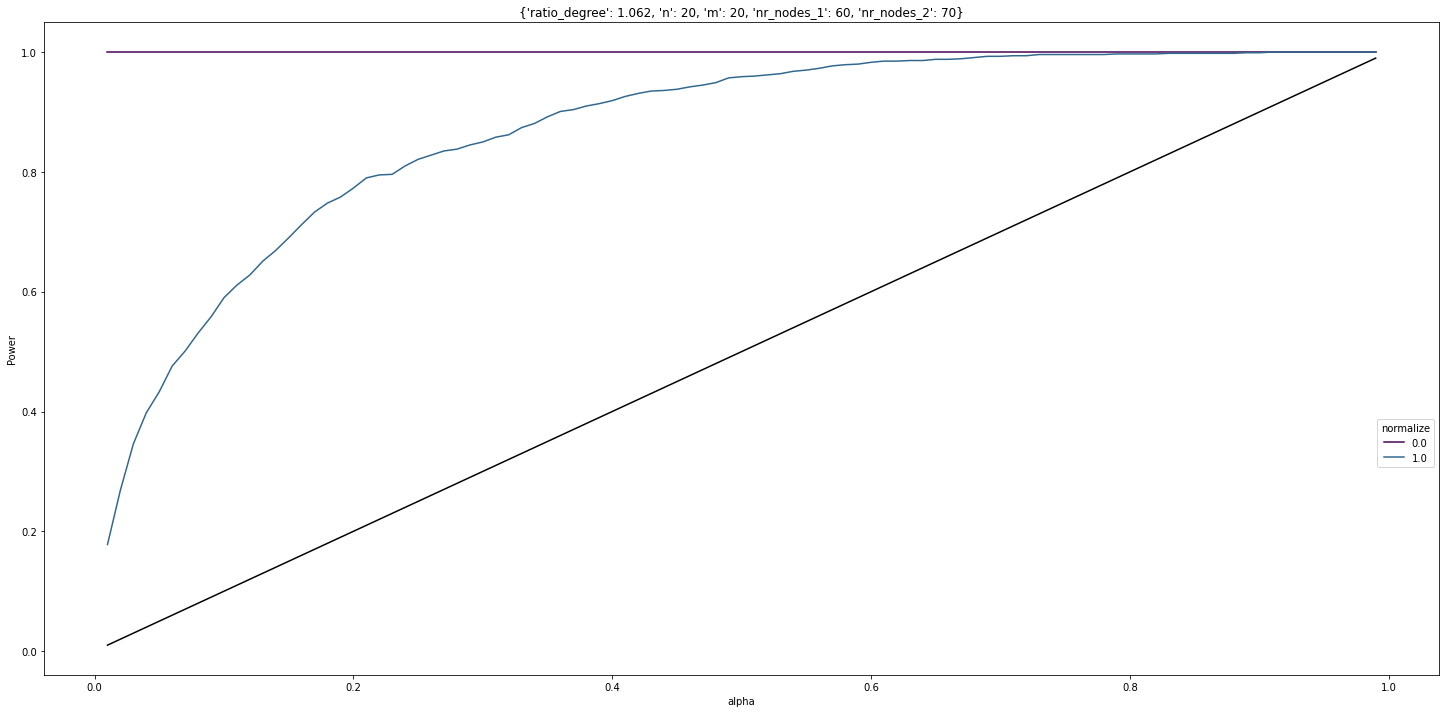

In [13]:
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':70
                #'normalize':1
                }


plotVaryingBGDEG(df = SP.copy(), param_vary_name = "normalize", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

In [14]:
SP.columns


Index(['kernel', 'alpha', 'nr_nodes_1', 'nr_nodes_2', 'p_edge_1', 'p_edge_2',
       'degree_1', 'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm', 'timestap',
       'B', 'N', 'run_time', 'average_degree', 'median_degree',
       'avg_neigh_degree', 'avg_clustering', 'transitivity', 'MMD_b',
       'MMD_b_distfree', 'MMD_u', 'MMD_u_distfree', 'normalize', 'with_labels',
       'sinkhorn'],
      dtype='object')

In [138]:
sp_params = ['normalize']
SP_AUC = findAUC(keys = keys, params = sp_params, stats = ['MMD_b', 'MMD_u'], df = SP )

# WWL

In [19]:
WWL = readfoldertopanda("../data/BGDegreeLabel/WWL")
WWL.columns



Index(['kernel', 'alpha', 'normalize', 'nr_nodes_1', 'nr_nodes_2', 'p_edge_1',
       'p_edge_2', 'degree_1', 'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm',
       'timestap', 'B', 'N', 'run_time', 'MMD_b', 'MMD_b_distfree', 'MMD_u',
       'MMD_u_distfree', 'nitr', 'with_labels', 'discount', 'sinkhorn',
       'wl_itr', 'average_degree', 'median_degree', 'avg_neigh_degree',
       'avg_clustering', 'transitivity'],
      dtype='object')

In [26]:
# Because of some changes I created different coumns for same parameter. I need to put all the information into one parameter

WWL.loc[WWL['nitr'].isna(), 'nitr'] = WWL.loc[WWL['nitr'].isna(), 'wl_itr']



In [35]:
np.unique(WWL['n'])

array([ 10,  20,  60, 100], dtype=int64)

c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


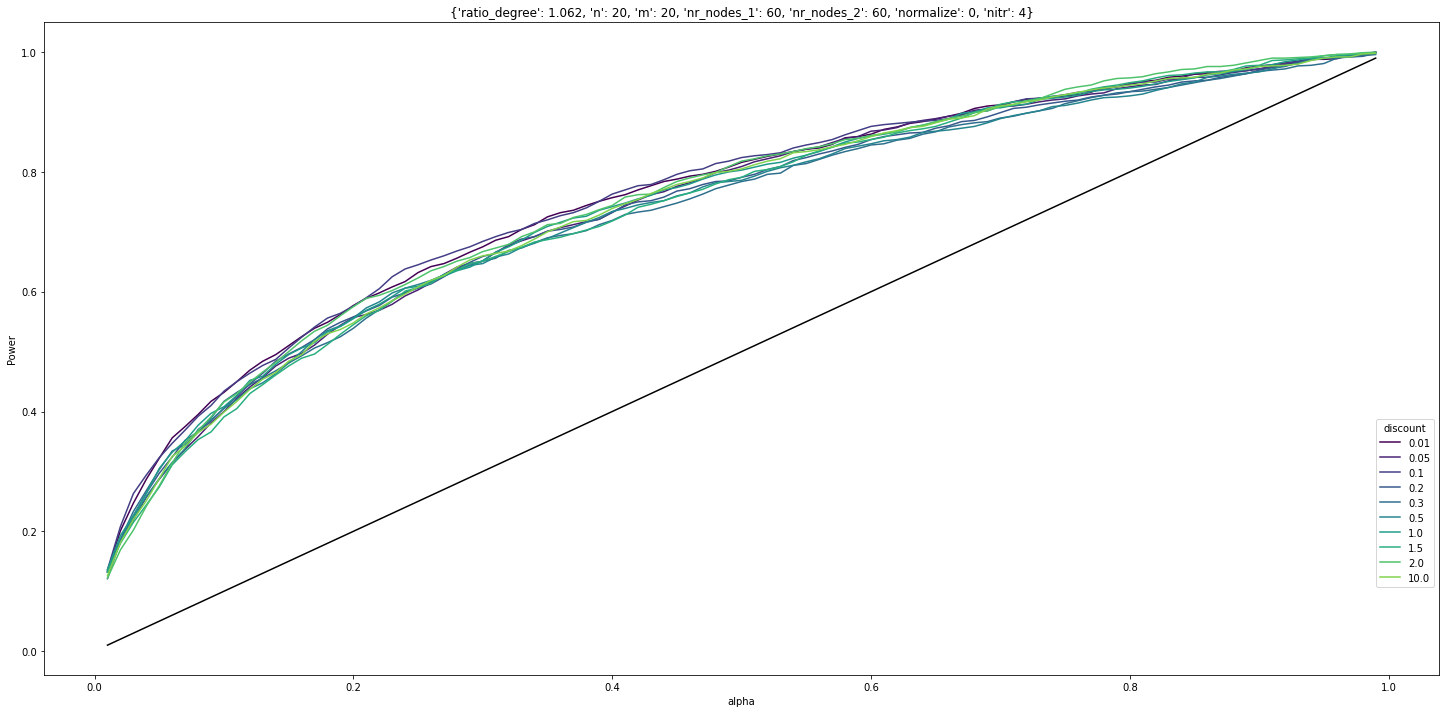

In [27]:

params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0,
                'nitr':4
                }

plotVaryingBGDEG(df = WWL.copy(), param_vary_name = "discount", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

In [38]:
WWL.columns

Index(['kernel', 'alpha', 'normalize', 'nr_nodes_1', 'nr_nodes_2', 'p_edge_1',
       'p_edge_2', 'degree_1', 'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm',
       'timestap', 'B', 'N', 'run_time', 'MMD_b', 'MMD_b_distfree', 'MMD_u',
       'MMD_u_distfree', 'nitr', 'with_labels', 'discount', 'sinkhorn',
       'wl_itr', 'average_degree', 'median_degree', 'avg_neigh_degree',
       'avg_clustering', 'transitivity'],
      dtype='object')

In [28]:
wwl_params = ['normalize', 'sinkhorn', 'discount', 'nitr']
WWL_AUC = findAUC(keys = keys, params = wwl_params, stats = ['MMD_b', 'MMD_u'], df = WWL )

# Propagation

In [30]:
PROP = readfoldertopanda("../data/BGDegreeLabel/PROP")
PROP.columns

Index(['kernel', 'alpha', 'normalize', 't_max', 'binwidth', 'M_distance',
       'nr_nodes_1', 'nr_nodes_2', 'p_edge_1', 'p_edge_2', 'degree_1',
       'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm', 'timestap', 'B', 'N',
       'run_time', 'MMD_b', 'MMD_b_distfree', 'MMD_u', 'MMD_u_distfree',
       'average_degree', 'median_degree', 'avg_neigh_degree', 'avg_clustering',
       'transitivity', 'with_labels', 'w', 'tmax', 'M', 'sinkhorn'],
      dtype='object')

In [33]:
# Because of some changes I created different coumns for same parameter. I need to put all the information into one parameter

PROP.loc[PROP['w'].isna(), 'w'] = PROP.loc[PROP['w'].isna(), 'binwidth']
PROP.loc[PROP['tmax'].isna(), 'tmax'] = PROP.loc[PROP['tmax'].isna(), 't_max']
PROP.loc[PROP['M'].isna(), 'M'] = PROP.loc[PROP['M'].isna(), 'M_distance']

In [34]:
print(np.unique(df['n']))
print(np.unique(df['m']))
print(np.unique(df['nr_nodes_1']))
print(np.unique(df['nr_nodes_2']))

[ 10  20  40  60 100]
[ 10  20  40  60 100]
[20 60 80]
[20 60 80]


c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


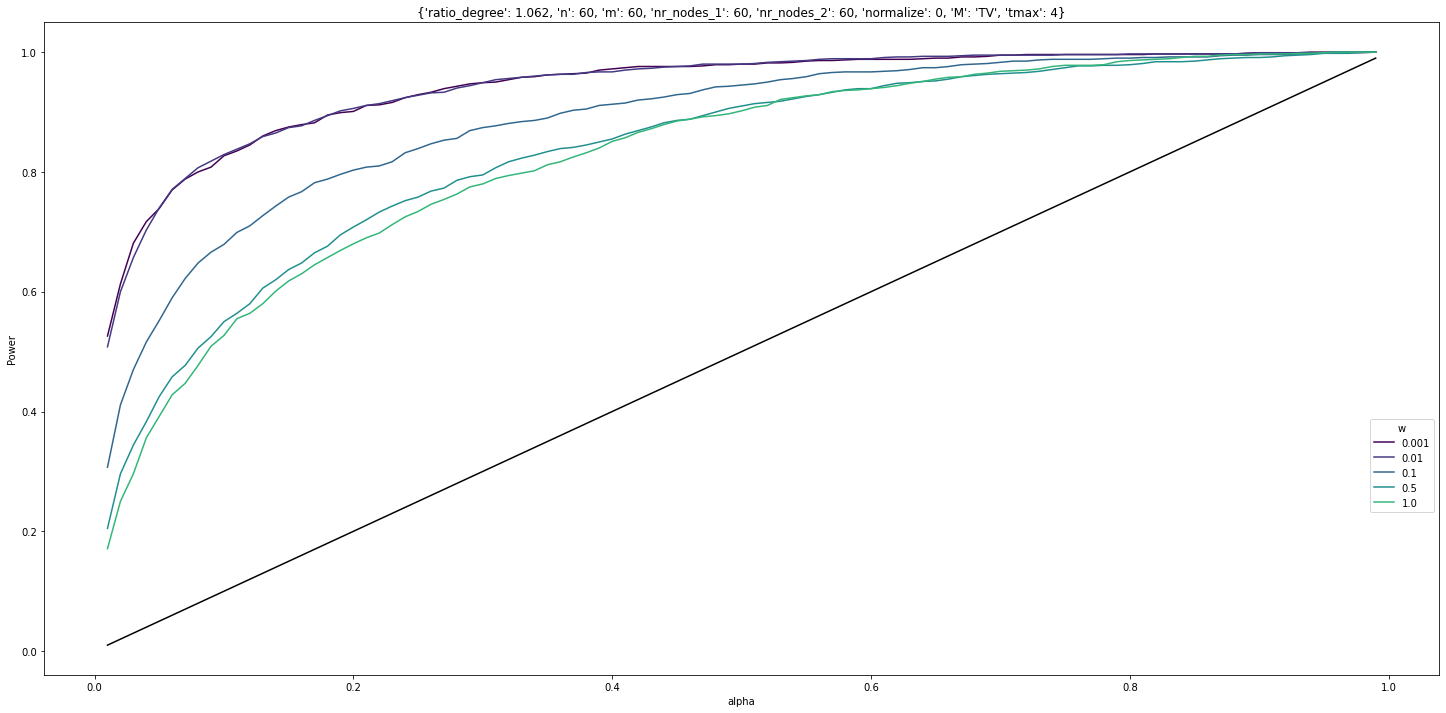

In [35]:

#print(sorted(np.unique(df['ratio_degree']))[0])
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':60,
                'm':60,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0,
                'M':'TV',
                #'w':0.001
                'tmax':4
                }

plotVaryingBGDEG(df = PROP.copy(), param_vary_name = "w", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

Will reject more often with lower width

c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


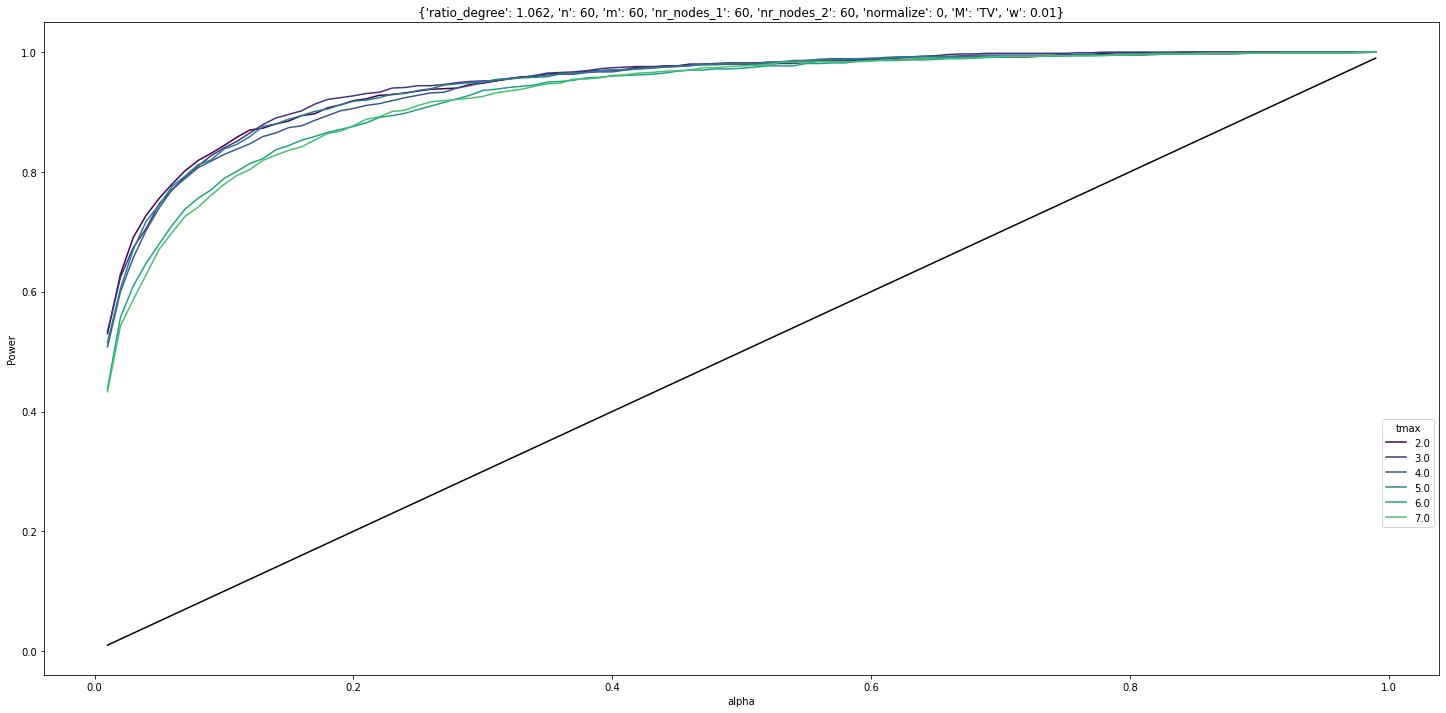

In [37]:

#print(sorted(np.unique(df['ratio_degree']))[0])
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':60,
                'm':60,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0,
                'M':'TV',
                'w':0.01
                }

plotVaryingBGDEG(df = PROP.copy(), param_vary_name = "tmax", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

tmax does not matter for degree labels

In [39]:
prop_params = ['normalize', 'tmax', 'w', 'M']
PROP_AUC = findAUC(keys = keys, params = prop_params, stats = ['MMD_b', 'MMD_u'], df = PROP )

# Pyramid

In [40]:
PYRAMID = readfoldertopanda("../data/BGDegreeLabel/PYRAMID")
PYRAMID.columns

Index(['kernel', 'alpha', 'normalize', 'L', 'd', 'nr_nodes_1', 'nr_nodes_2',
       'p_edge_1', 'p_edge_2', 'degree_1', 'degree_2', 'ratio_p',
       'ratio_degree', 'n', 'm', 'timestap', 'B', 'N', 'run_time', 'MMD_b',
       'MMD_b_distfree', 'MMD_u', 'MMD_u_distfree', 'average_degree',
       'median_degree', 'avg_neigh_degree', 'avg_clustering', 'transitivity',
       'with_labels', 'dim', 'sinkhorn'],
      dtype='object')

In [41]:
# Because of some changes I created different coumns for same parameter. I need to put all the information into one parameter

PYRAMID.loc[PYRAMID['dim'].isna(), 'dim'] = PYRAMID.loc[PYRAMID['dim'].isna(), 'd']


c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


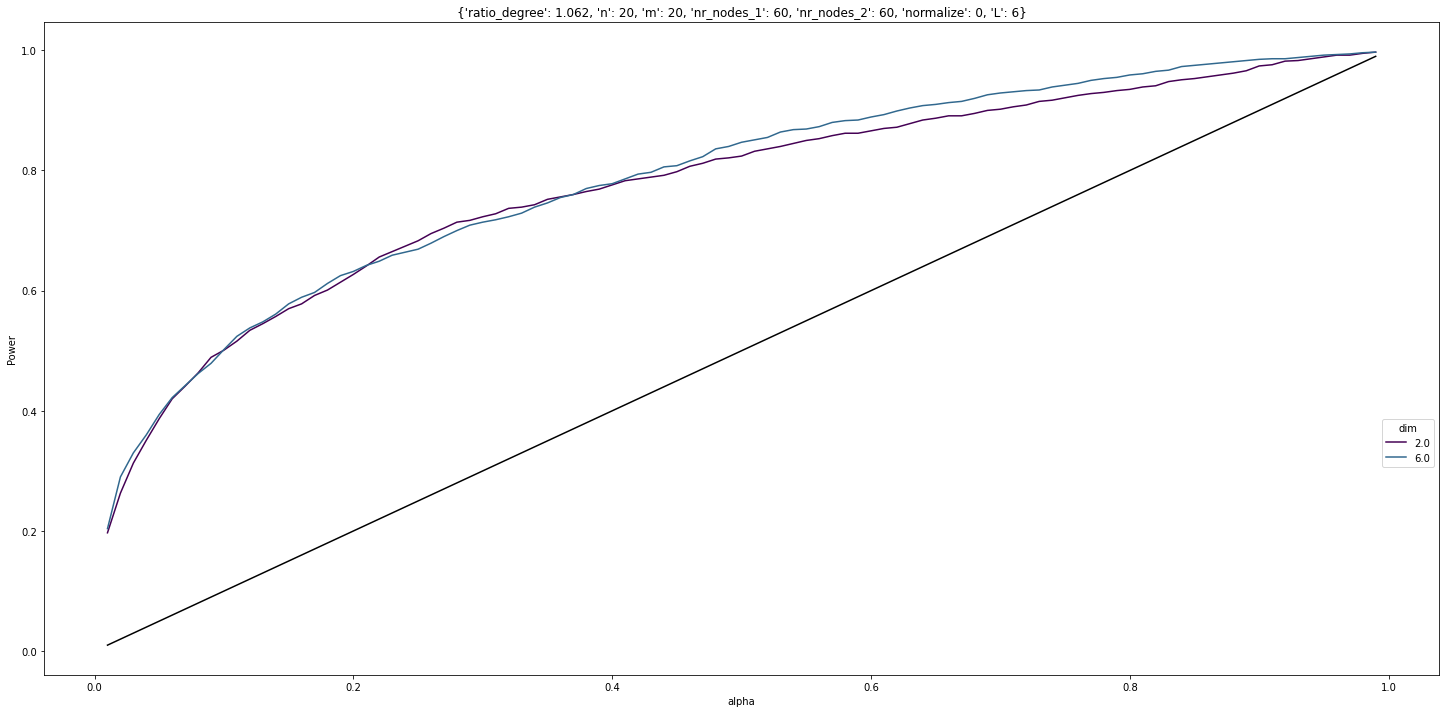

In [42]:
#print(sorted(np.unique(df['ratio_degree']))[0])
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0,
                #'dim':2,
                'L':6
                }

plotVaryingBGDEG(df = PYRAMID.copy(), param_vary_name = "dim", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

In [61]:
sorted(np.unique(df['ratio_degree']))[0]

1.062

c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


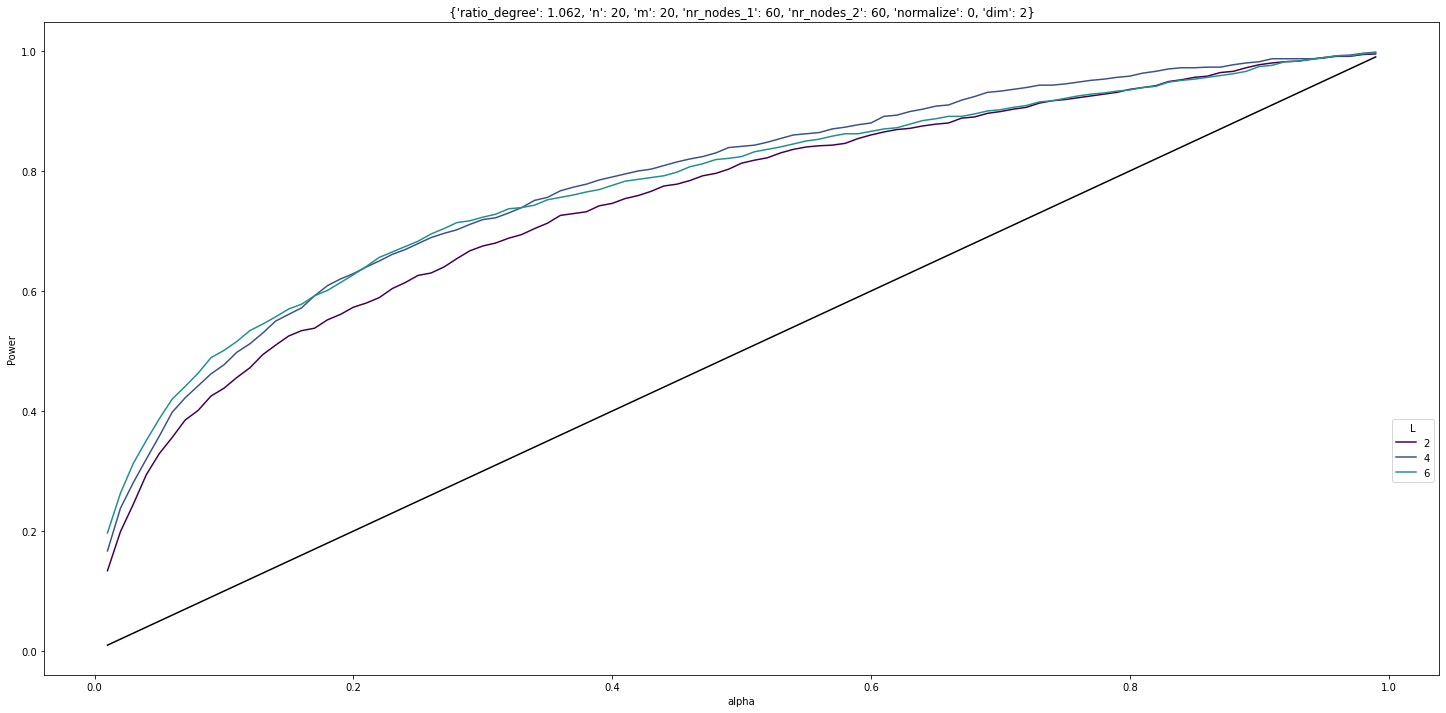

In [43]:
#print(sorted(np.unique(df['ratio_degree']))[0])
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0,
                'dim':2
                #'L':6
                }

plotVaryingBGDEG(df = PYRAMID.copy(), param_vary_name = "L", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

Too large L will make the kernel very diagonally dominant.

c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


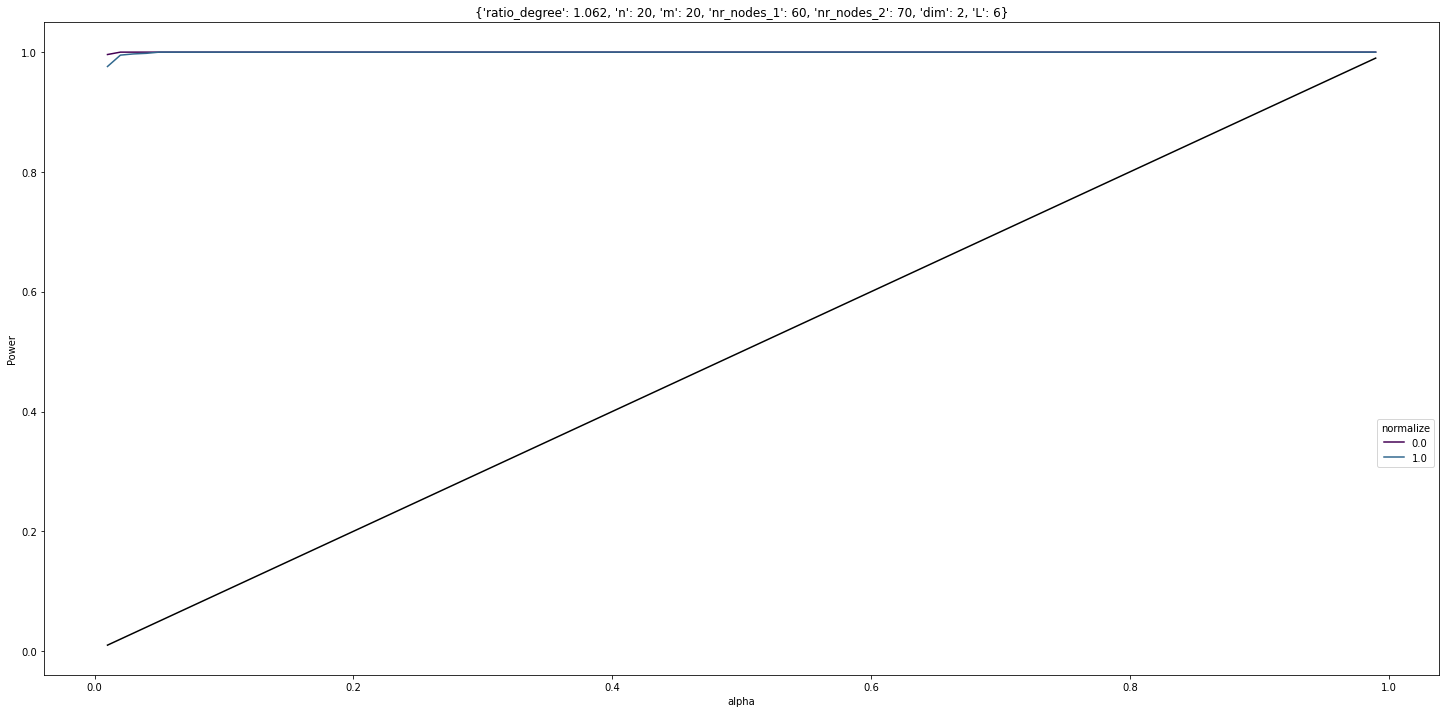

In [44]:
#print(sorted(np.unique(df['ratio_degree']))[0])
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':70,
                'dim':2,
                'L':6
                }

plotVaryingBGDEG(df = PYRAMID.copy(), param_vary_name = "normalize", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

In [34]:
PYRAMID.columns

Index(['kernel', 'alpha', 'normalize', 'L', 'd', 'nr_nodes_1', 'nr_nodes_2',
       'p_edge_1', 'p_edge_2', 'degree_1', 'degree_2', 'ratio_p',
       'ratio_degree', 'n', 'm', 'timestap', 'B', 'N', 'run_time', 'MMD_b',
       'MMD_b_distfree', 'MMD_u', 'MMD_u_distfree', 'average_degree',
       'median_degree', 'avg_neigh_degree', 'avg_clustering', 'transitivity'],
      dtype='object')

In [45]:
pyramid_params = ['normalize', 'L', 'dim']
PYRAMID_AUC = findAUC(keys = keys, params = pyramid_params, stats = ['MMD_b', 'MMD_u'], df = PYRAMID )

# WLOA

In [48]:
WLOA = readfoldertopanda("../data/BGDegreeLabel/WLOA")
print(WLOA.columns)
print(np.unique(df['n']))
print(np.unique(df['m']))
print(np.unique(df['nr_nodes_1']))
print(np.unique(df['nr_nodes_2']))

Index(['kernel', 'alpha', 'normalize', 'nr_nodes_1', 'nr_nodes_2', 'p_edge_1',
       'p_edge_2', 'degree_1', 'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm',
       'timestap', 'B', 'N', 'run_time', 'MMD_b', 'MMD_b_distfree', 'MMD_u',
       'MMD_u_distfree', 'nitr', 'with_labels', 'sinkhorn', 'wl_itr',
       'average_degree', 'median_degree', 'avg_neigh_degree', 'avg_clustering',
       'transitivity'],
      dtype='object')
[ 10  20  40  60 100]
[ 10  20  40  60 100]
[20 60 80]
[20 60 80]


In [49]:
# Because of some changes I created different coumns for same parameter. I need to put all the information into one parameter

WLOA.loc[WLOA['nitr'].isna(), 'nitr'] = WLOA.loc[WLOA['nitr'].isna(), 'wl_itr']


c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


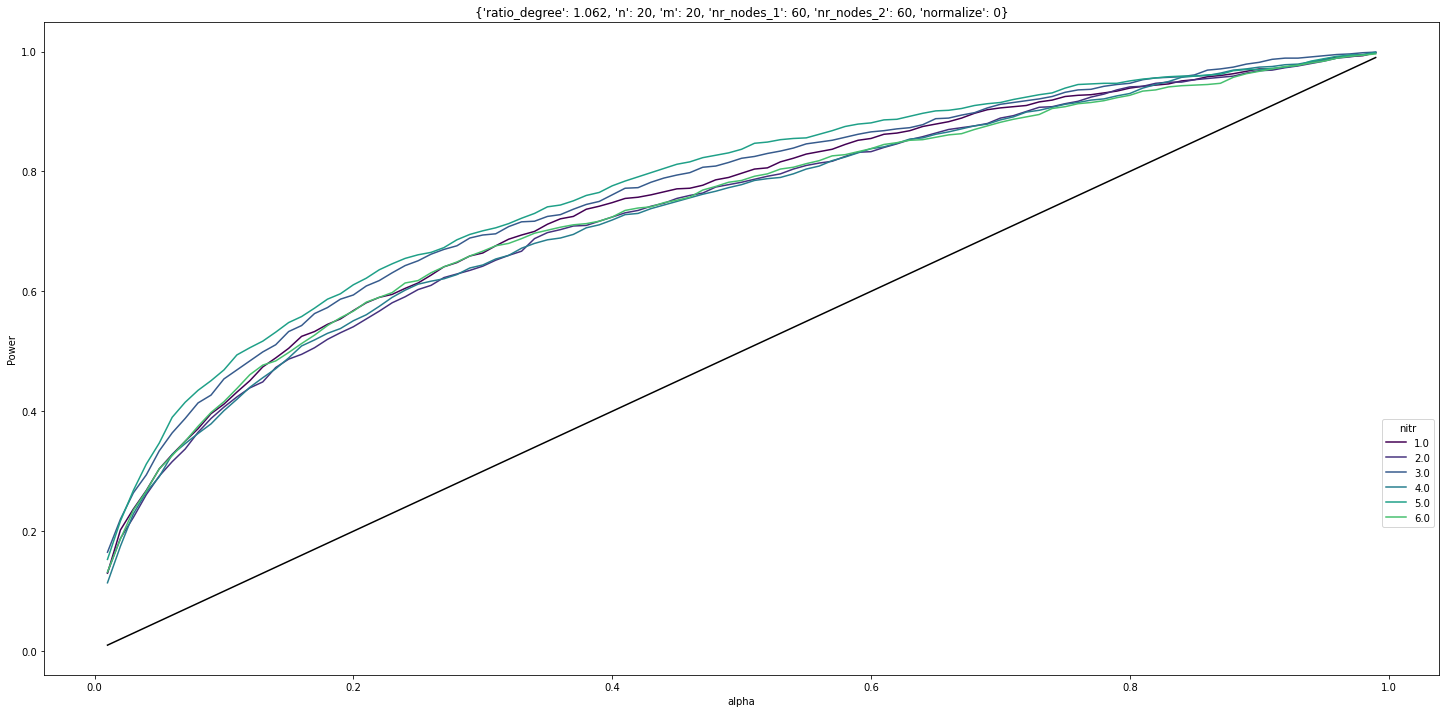

In [50]:
#print(sorted(np.unique(df['ratio_degree']))[0])
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0
                }

plotVaryingBGDEG(df = WLOA.copy(), param_vary_name = "nitr", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


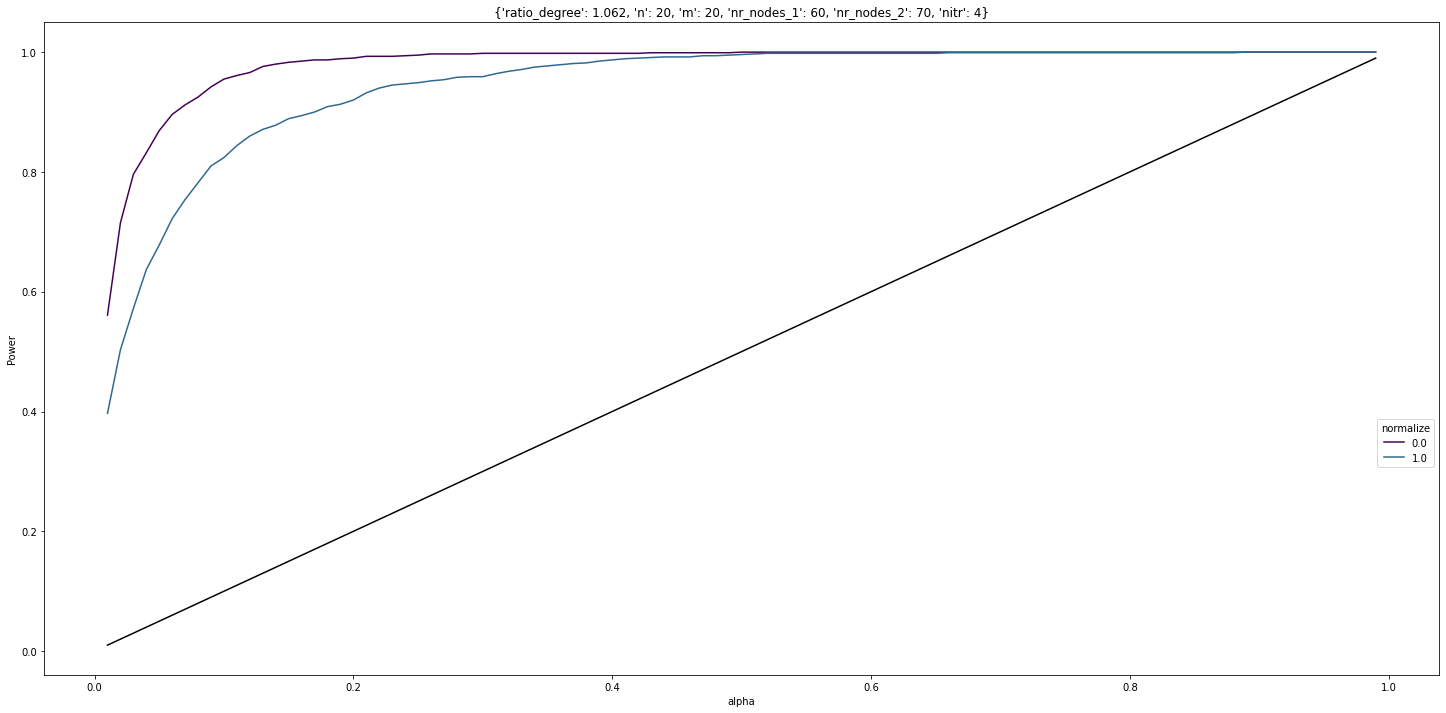

In [51]:
#print(sorted(np.unique(df['ratio_degree']))[0])
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':70,
                'nitr':4
                }

plotVaryingBGDEG(df = WLOA.copy(), param_vary_name = "normalize", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

In [52]:
wloa_params = ['normalize', 'nitr']
WLOA_AUC = findAUC(keys = keys, params = wloa_params, stats = ['MMD_b', 'MMD_u'], df = WLOA )

# VH

In [53]:
VH = readfoldertopanda("../data/BGDegreeLabel/VH")
print(np.unique(df['n']))
print(np.unique(df['m']))
print(np.unique(df['nr_nodes_1']))
print(np.unique(df['nr_nodes_2']))

[ 10  20  40  60 100]
[ 10  20  40  60 100]
[20 60 80]
[20 60 80]


c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


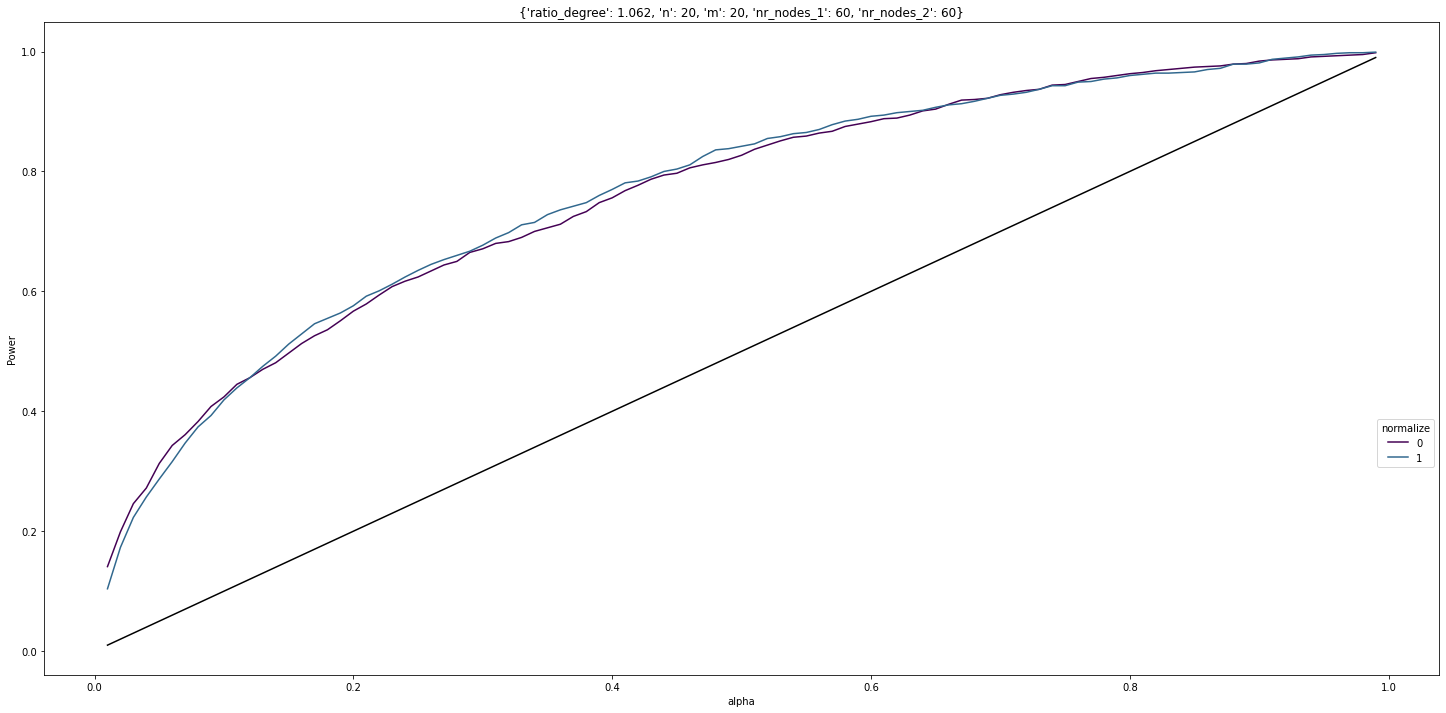

In [54]:
#print(sorted(np.unique(df['ratio_degree']))[0])
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60
                }

plotVaryingBGDEG(df = VH.copy(), param_vary_name = "normalize", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

In [55]:
vh_params = ['normalize']
VH_AUC = findAUC(keys = keys, params = vh_params, stats = ['MMD_b', 'MMD_u'], df = VH )

# ODD

In [56]:
ODD = readfoldertopanda("../data/BGDegreeLabel/ODD")
print(ODD.columns)
print(np.unique(df['n']))
print(np.unique(df['m']))
print(np.unique(df['nr_nodes_1']))
print(np.unique(df['nr_nodes_2']))

Index(['kernel', 'alpha', 'normalize', 'dag_depth', 'nr_nodes_1', 'nr_nodes_2',
       'p_edge_1', 'p_edge_2', 'degree_1', 'degree_2', 'ratio_p',
       'ratio_degree', 'n', 'm', 'timestap', 'B', 'N', 'run_time', 'MMD_b',
       'MMD_b_distfree', 'MMD_u', 'MMD_u_distfree', 'with_labels', 'dagh',
       'sinkhorn'],
      dtype='object')
[ 10  20  40  60 100]
[ 10  20  40  60 100]
[20 60 80]
[20 60 80]


In [57]:
# Because of some changes I created different coumns for same parameter. I need to put all the information into one parameter

ODD.loc[ODD['dagh'].isna(), 'dagh'] = ODD.loc[ODD['dagh'].isna(), 'dag_depth']


c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


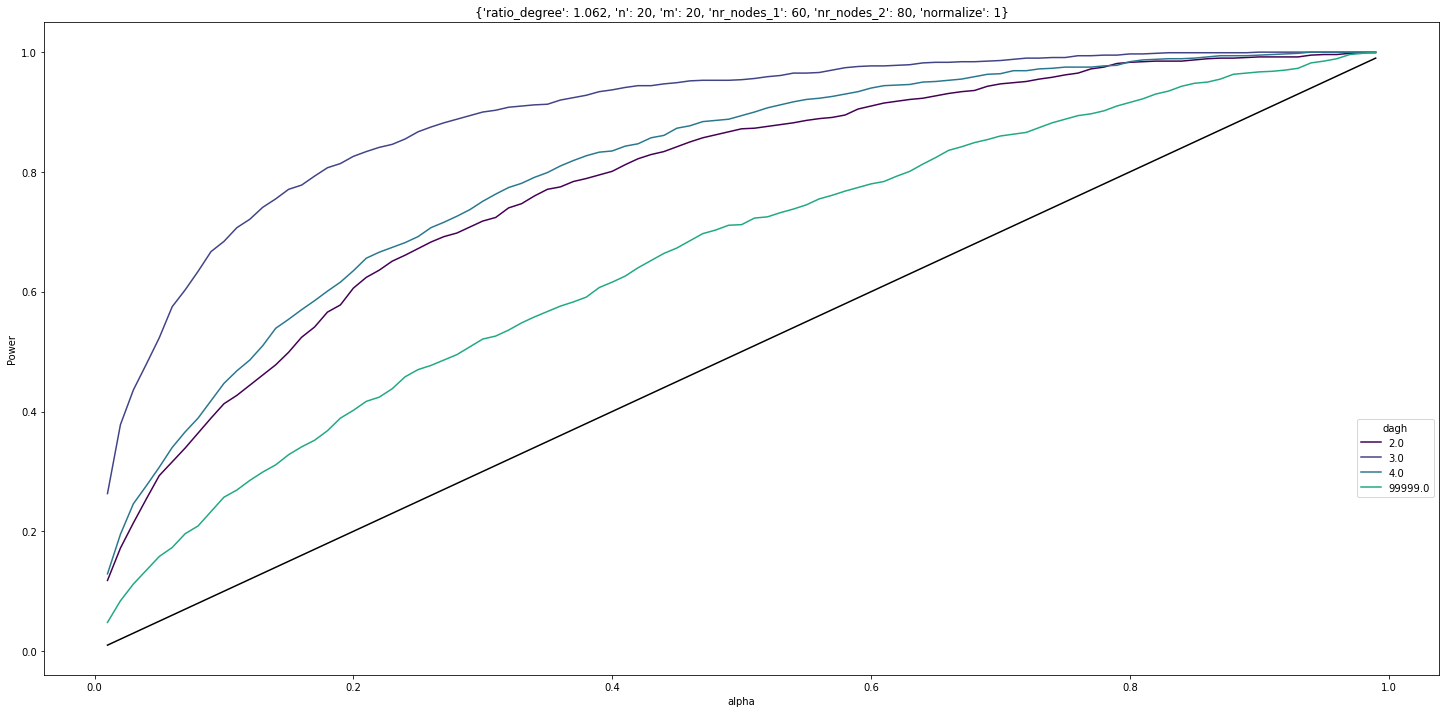

In [60]:
#print(sorted(np.unique(df['ratio_degree']))[0])
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':80,
                'normalize':1
                }

plotVaryingBGDEG(df = ODD.copy(), param_vary_name = "dagh", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

Seems like the dag_depth should not be too high

In [61]:
odd_params = ['normalize', 'dagh']
ODD_AUC = findAUC(keys = keys, params = odd_params, stats = ['MMD_b', 'MMD_u'], df = ODD )

# DK

In [63]:
DK = readfoldertopanda("../data/BGDegreeLabel/DK")
print(DK.columns)
print(np.unique(df['n']))
print(np.unique(df['m']))
print(np.unique(df['nr_nodes_1']))
print(np.unique(df['nr_nodes_2']))

Index(['kernel', 'alpha', 'normalize', 'dk_type', 'wl_itr', 'nr_nodes_1',
       'nr_nodes_2', 'p_edge_1', 'p_edge_2', 'degree_1', 'degree_2', 'ratio_p',
       'ratio_degree', 'n', 'm', 'timestap', 'B', 'N', 'run_time', 'MMD_b',
       'MMD_b_distfree', 'MMD_u', 'MMD_u_distfree', 'nitr', 'with_labels',
       'type', 'sinkhorn'],
      dtype='object')
[ 10  20  40  60 100]
[ 10  20  40  60 100]
[20 60 80]
[20 60 80]


In [64]:
# Because of some changes I created different coumns for same parameter. I need to put all the information into one parameter

DK.loc[DK['type'].isna(), 'type'] = DK.loc[DK['type'].isna(), 'dk_type']
DK.loc[DK['nitr'].isna(), 'nitr'] = DK.loc[DK['nitr'].isna(), 'wl_itr']


c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


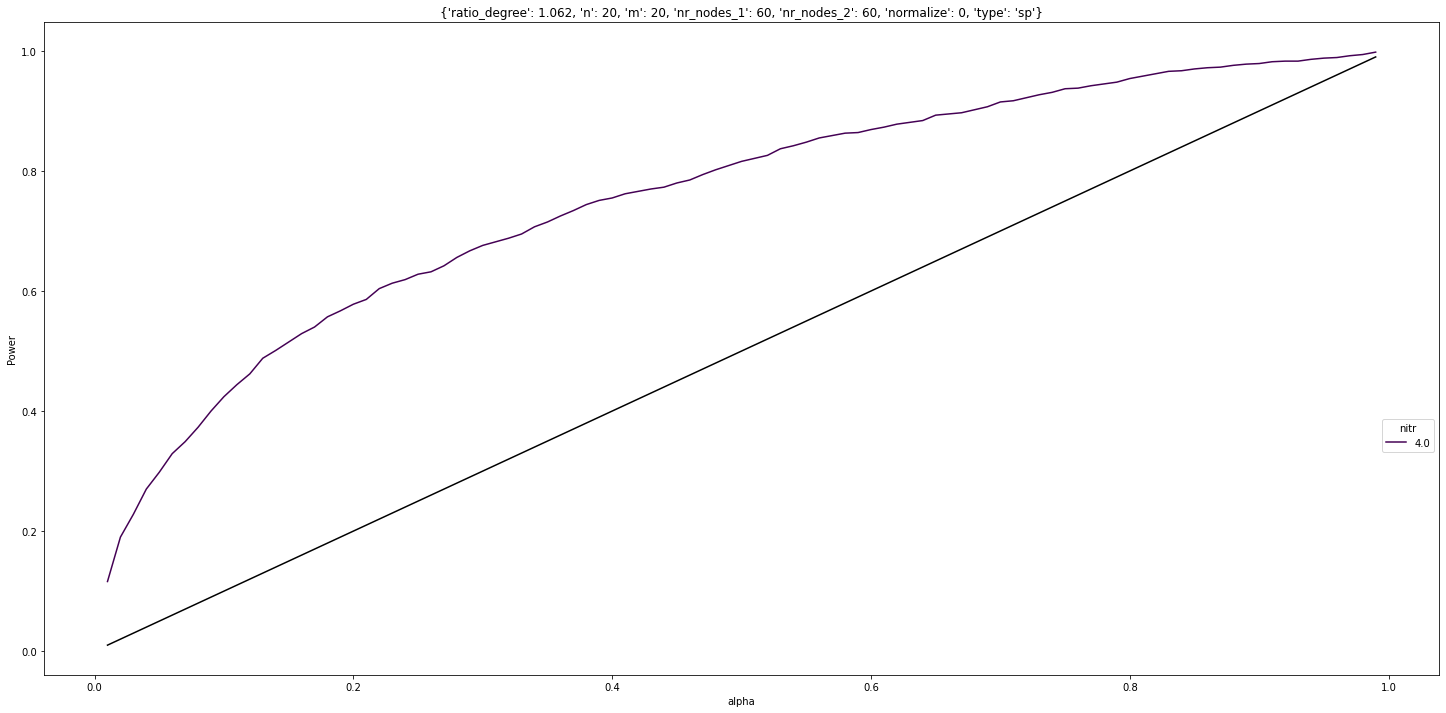

In [65]:
#print(sorted(np.unique(df['ratio_degree']))[0])
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0,
                'type':'sp'
                }

plotVaryingBGDEG(df = DK.copy(), param_vary_name = "nitr", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


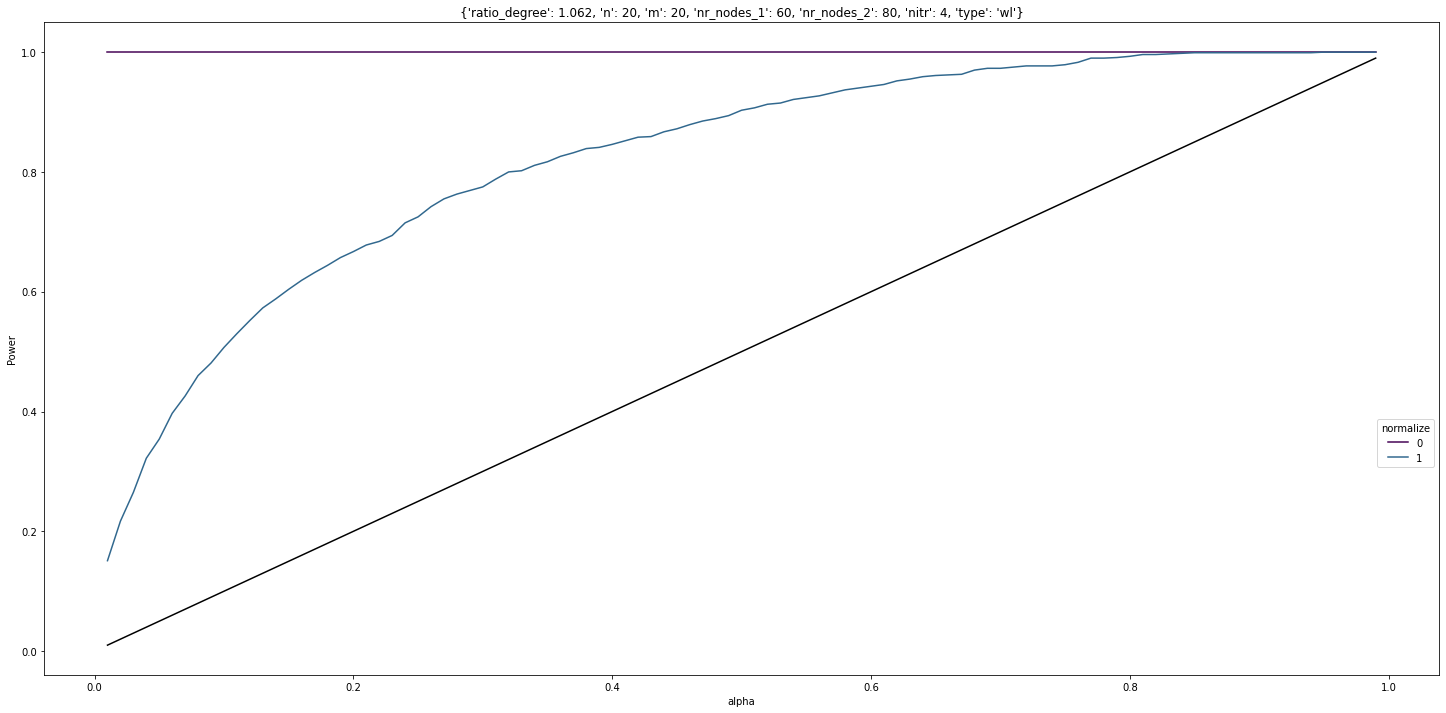

In [68]:
#print(sorted(np.unique(df['ratio_degree']))[0])
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':80,
                'nitr':4,
                'type':'wl'
                }

plotVaryingBGDEG(df = DK.copy(), param_vary_name = "normalize", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

In [69]:
dk_params = ['normalize', 'type', 'nitr']
DK_AUC = findAUC(keys = keys, params = dk_params, stats = ['MMD_b', 'MMD_u'], df = DK )

# Comparing all with best params

In [135]:
sp_max

,index,nr_nodes_1,nr_nodes_2,degree_1,degree_2,n,m,normalize,MMD_b_auc,MMD_u_auc
0,0,60,60,4.0,4.25,60,60,NaN,0.353904,0.353904


In [139]:

key_pair = pd.DataFrame({'nr_nodes_1':60, 
            'nr_nodes_2':60, 
            'degree_1':4,
            'degree_2':4.25, 
            'n':60, 
            'm':60}, index = [0])

stat = 'MMD_u_auc'
stat_plot = 'MMD_u'

best = []



vh_max = VH_AUC.reset_index().merge(key_pair, on = keys)
vh_max = vh_max[vh_max.groupby(['nr_nodes_1', 'nr_nodes_2', 'degree_1','degree_2', 'n', 'm'])[stat].transform(max) == vh_max[stat]].iloc[[0]]
tmp_vh = VH.reset_index().merge(vh_max, on = keys + vh_params)
tmp_vh['kernel_name'] = 'VH'
best.append(tmp_vh)

wl_max = WL_AUC.reset_index().merge(key_pair, on = keys)
wl_max = wl_max[wl_max.groupby(['nr_nodes_1', 'nr_nodes_2', 'degree_1','degree_2', 'n', 'm'])[stat].transform(max) == wl_max[stat]].iloc[[0]]
tmp_wl = WL.reset_index().merge(wl_max, on = keys + wl_params)
tmp_wl['kernel_name'] = 'WL'
best.append(tmp_wl)

sp_max = SP_AUC.reset_index().merge(key_pair, on = keys)
sp_max = sp_max[sp_max.groupby(['nr_nodes_1', 'nr_nodes_2', 'degree_1','degree_2', 'n', 'm'])[stat].transform(max) == sp_max[stat]].iloc[[0]]
tmp_sp = SP.reset_index().merge(sp_max, on = keys + sp_params)
tmp_sp['kernel_name'] = 'SP'
best.append(tmp_sp)

prop_max = PROP_AUC.reset_index().merge(key_pair, on = keys) #PROP_AUC.loc[(PROP_AUC['w']!=0.001) & (PROP_AUC['w']!=0.5)].reset_index().merge(key_pair, on = keys)
prop_max = prop_max[prop_max.groupby(['nr_nodes_1', 'nr_nodes_2', 'degree_1','degree_2', 'n', 'm'])[stat].transform(max) == prop_max[stat]].iloc[[0]]
tmp_prop = PROP.reset_index().merge(prop_max, on = keys + prop_params)
tmp_prop['kernel_name'] = 'PROP'
best.append(tmp_prop)

wwl_max = WWL_AUC.reset_index().merge(key_pair, on = keys)
wwl_max = wwl_max[wwl_max.groupby(['nr_nodes_1', 'nr_nodes_2', 'degree_1','degree_2', 'n', 'm'])[stat].transform(max) == wwl_max[stat]].iloc[[0]]
tmp_wwl = WWL.reset_index().merge(wwl_max, on = keys + wwl_params)
tmp_wwl['kernel_name'] = 'WWL'
best.append(tmp_wwl)

odd_max = ODD_AUC.reset_index().merge(key_pair, on = keys)
odd_max = odd_max[odd_max.groupby(['nr_nodes_1', 'nr_nodes_2', 'degree_1','degree_2', 'n', 'm'])[stat].transform(max) == odd_max[stat]].iloc[[0]]
tmp_odd = ODD.reset_index().merge(odd_max, on = keys + odd_params)
tmp_odd['kernel_name'] = 'ODD'
best.append(tmp_odd)

wloa_max = WLOA_AUC.reset_index().merge(key_pair, on = keys)
wloa_max = wloa_max[wloa_max.groupby(['nr_nodes_1', 'nr_nodes_2', 'degree_1','degree_2', 'n', 'm'])[stat].transform(max) == wloa_max[stat]].iloc[[0]]
tmp_wloa = WLOA.reset_index().merge(wloa_max, on = keys + wloa_params)
tmp_wloa['kernel_name'] = 'WLOA'
best.append(tmp_wloa)

dk_max = DK_AUC.reset_index().merge(key_pair, on = keys)
dk_max = dk_max[dk_max.groupby(['nr_nodes_1', 'nr_nodes_2', 'degree_1','degree_2', 'n', 'm'])[stat].transform(max) == dk_max[stat]].iloc[[0]]
tmp_dk = DK.reset_index().merge(dk_max, on = keys + dk_params)
tmp_dk['kernel_name'] = 'DK'
best.append(tmp_dk)


graph_stat = GRAPHSTATS.reset_index().merge(key_pair, on = keys)





#idx = wl_auc.groupby(['nr_nodes_1', 'nr_nodes_2', 'degree_1','degree_2', 'n', 'm'])['MMD_u_auc'].transform(max) == wl_auc['MMD_b_auc']


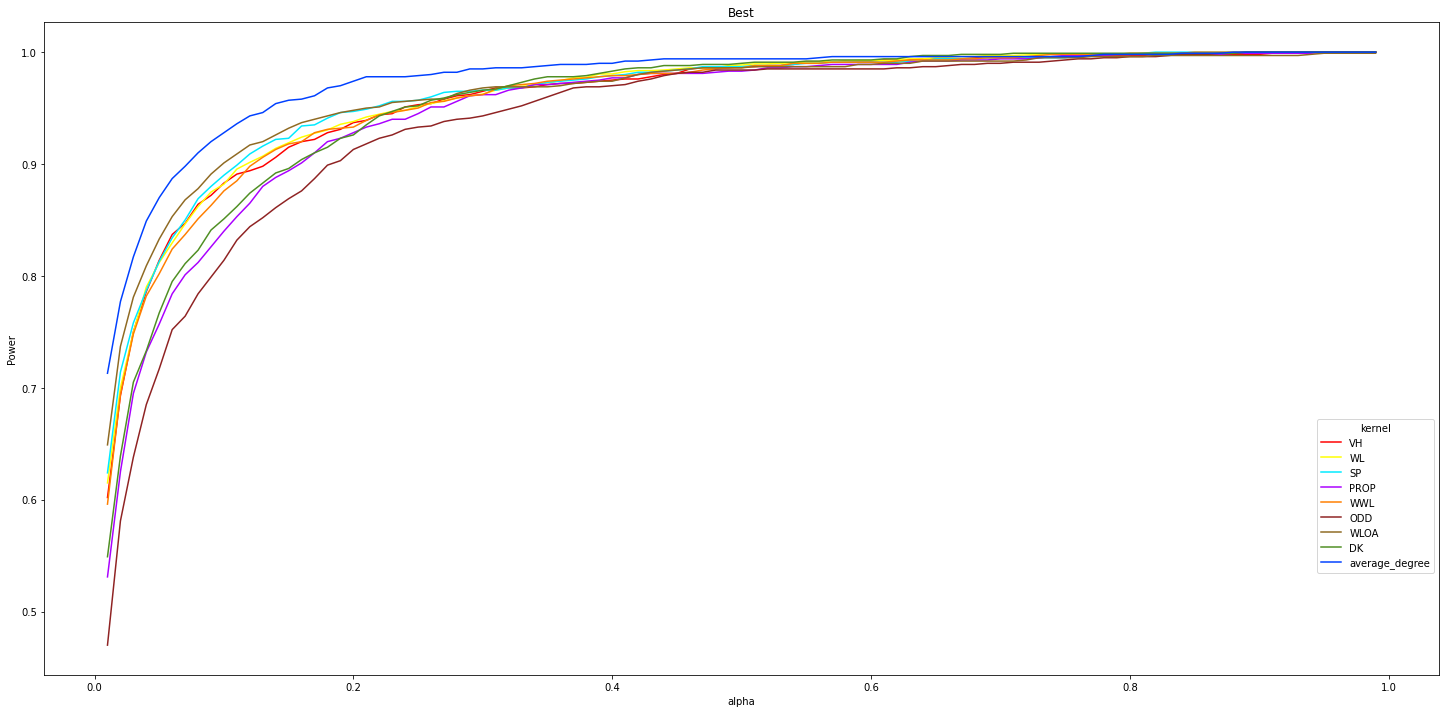

In [140]:
_, ax = plt.subplots(figsize = (25,12))


label = []
#icefire
#cmap = get_cmap(sns.color_palette("viridis", as_cmap=True)) # type: matplotlib.colors.ListedColormap
colors = ['#FF0000', '#FFFF00', '#00EAFF', '#AA00FF', '#FF7F00', '#8F2323', '#8F6A23', '#4F8F23', '#0040FF', '#737373', '#23628F']# cmap.colors[::int(len(cmap.colors)/(7+1))]  # type: list

for i,row in enumerate(best):

    ax.plot(row['alpha'], row[stat_plot], color =colors[i], label=str(row['kernel_name'].iloc[0]))
    label.append(str(row['kernel_name'].iloc[0]))


ax.plot(graph_stat['alpha'], graph_stat['average_degree'], color =colors[i+1], label='average_degree')
label.append('average_degree')



h, l = ax.get_legend_handles_labels()

ax.legend(handles=h, labels=label, 
        handler_map = {tuple: matplotlib.legend_handler.HandlerTuple(None)}, title = 'kernel', bbox_to_anchor=(1, 0.4))

ax.set_xlabel('alpha')
ax.set_ylabel('Power')
ax.set_title(f'Best')


plt.show()

# Testing cpus


8


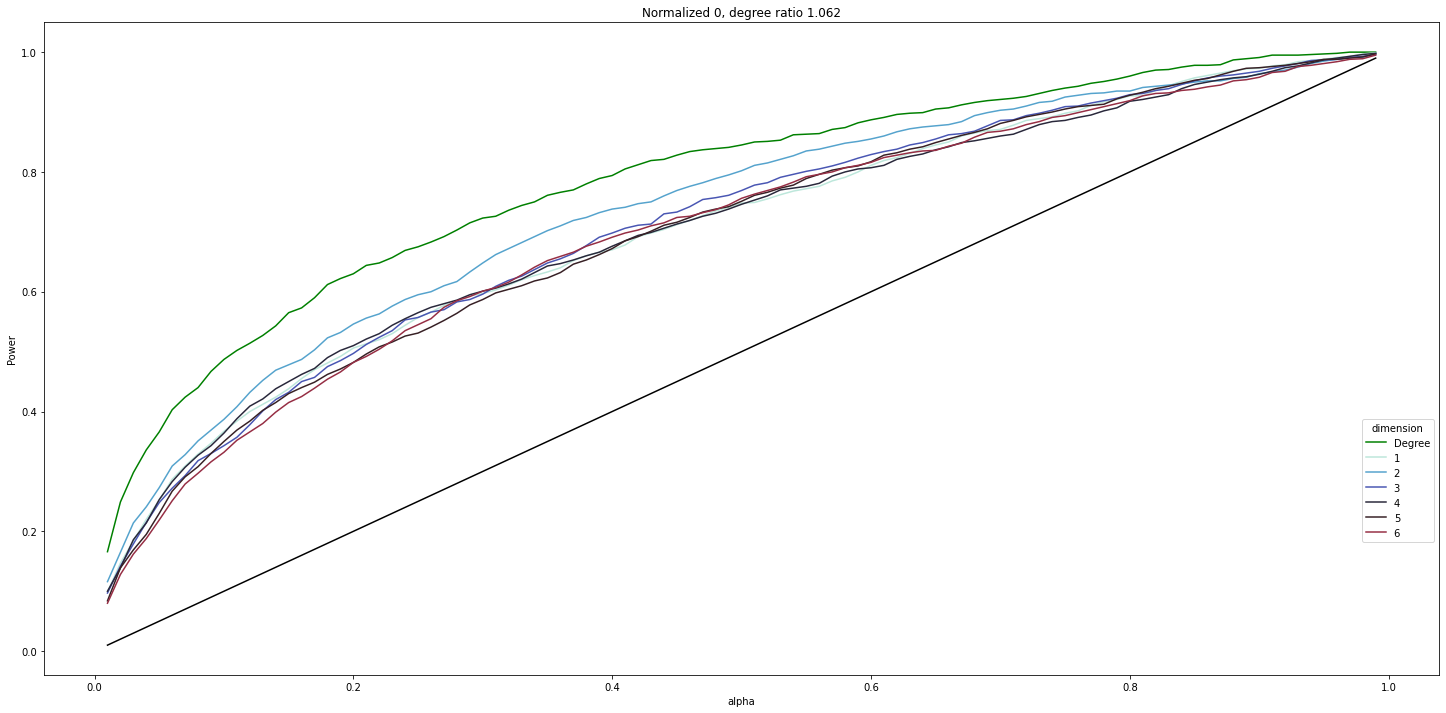

In [33]:
df = WLOA
normalize = 0
mmd_stat = "MMD_b"
v = sorted(np.unique(df['ratio_degree']))[0]
n1 = 20
n2 = n1
nr_nodes_1 = 40
nr_nodes_2 = nr_nodes_1
param_values = sorted(np.unique(df['wl_itr']))

_, ax = plt.subplots(figsize = (25,12))

label = []

name = "Dark2" 
cmap = get_cmap(sns.color_palette("icefire", as_cmap=True), lut = len(param_values)) # type: matplotlib.colors.ListedColormap
colors = cmap.colors[::int(len(cmap.colors)/(len(param_values)+1))]  # type: list
print(len(colors))

ab_line_plotted = False
graph_statistic_plotted = False

for cnt, param in enumerate(param_values):

        tmp = df.loc[(df['ratio_degree'] == v) & (df['wl_itr'] == param)  & (df['normalize'] == normalize) & (df['n'] == n1) & (df['m'] == n2) & (df['nr_nodes_1'] == nr_nodes_1) & (df['nr_nodes_2'] == nr_nodes_2) ]

        if not ab_line_plotted:
                y = tmp['alpha']
                if len(y)>0:
                        ax.plot(y, y, color = 'black')
                        ab_line_plotted = True
                        #label.append('line')

        if not graph_statistic_plotted:
                y = tmp['average_degree']
                if len(y) >0:
                        ax.plot(tmp['alpha'],
                                tmp['average_degree'], 
                                color ='g', label= "Degree")
                        graph_statistic_plotted = True
                        label.append('Degree')

        ax.plot(tmp['alpha'],tmp[mmd_stat], color =colors[cnt], label=str(v))

        label.append(param)
        



#ax.legend(label)
h, l = ax.get_legend_handles_labels()

ax.legend(handles=h, labels=label, 
        handler_map = {tuple: matplotlib.legend_handler.HandlerTuple(None)}, title = 'Wl_iterations', bbox_to_anchor=(1, 0.4))

ax.set_xlabel('alpha')
ax.set_ylabel('Power')
ax.set_title(f'Normalized {normalize}, degree ratio {v}')


plt.show()

In [ ]:
tmp1 = pd.read_pickle("../data/test_d_1.pkl")
tmp2 = pd.read_pickle("../data/test_d_2.pkl")
tmp3 = pd.read_pickle("../data/test_d_3.pkl")
tmp4 = pd.read_pickle("../data/test_d_4.pkl")

In [ ]:
normalize = 1
mmd_stat = "MMD_b"


_, ax = plt.subplots(figsize = (25,12))

ax.plot(tmp1['alpha'], tmp1[mmd_stat],color = 'red', label=str(1))
ax.plot(tmp2['alpha'], tmp2[mmd_stat],color = 'blue', label=str(2))
ax.plot(tmp3['alpha'], tmp3[mmd_stat],color = 'green', label=str(3))
ax.plot(tmp4['alpha'], tmp4[mmd_stat],color = 'yellow', label=str(4))

# ax.plot(tmp1['alpha'], tmp1['average_degree'], color = 'red', label=str(1))
# ax.plot(tmp2['alpha'], tmp2['average_degree'], color = 'blue', label=str(2))
# ax.plot(tmp3['alpha'], tmp3['average_degree'], color = 'green', label=str(3))
# ax.plot(tmp4['alpha'], tmp4['average_degree'], color = 'yellow', label=str(4))

    
h, l = ax.get_legend_handles_labels()

ax.legend()


ax.set_xlabel('alpha')
ax.set_ylabel('Power')


plt.show()

In [ ]:
bool(0.0)

# Testing Test

In [9]:
tmp1 = pd.read_pickle("../data/test.pkl")

In [ ]:
df = PYRAMID


def plotVaryingBGDEG(df, param_vary_name, params_vary, params_fixed, mmd_stat = "MMD_b", color_name = "viridis"):

        _, ax = plt.subplots(figsize = (25,12))

        label = []

        cmap = get_cmap(sns.color_palette(color_name, as_cmap=True), lut = len(params_vary)) # type: matplotlib.colors.ListedColormap
        colors = cmap.colors[::int(len(cmap.colors)/(len(params_vary)+1))]  # type: list
        print(len(colors))

        ab_line_plotted = False
        graph_statistic_plotted = False

        # select the fixed parameters
        for k,v in param_values.items():
                df = df.loc(df[k] == v).copy()


        for cnt, param in enumerate(param_values):

                tmp = df.loc[df[param_vary_name] == param].copy()

                if not ab_line_plotted:
                        y = tmp['alpha']
                        if len(y)>0:
                                ax.plot(y, y, color = 'black')
                                ab_line_plotted = True
                                #label.append('line')

                ax.plot(tmp['alpha'],tmp[mmd_stat], color =colors[cnt], label=str(v))

                label.append(param)
                



        #ax.legend(label)
        h, l = ax.get_legend_handles_labels()

        ax.legend(handles=h, labels=label, 
                handler_map = {tuple: matplotlib.legend_handler.HandlerTuple(None)}, title = 'dimension', bbox_to_anchor=(1, 0.4))

        ax.set_xlabel('alpha')
        ax.set_ylabel('Power')
        ax.set_title(f'Normalized {normalize}, degree ratio {v}')


        plt.show()